In [2]:
#Basic data handling libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

#For ADFuller, ACF, PACF, ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Boxcox Transformation to reduce Heteroskedasticity
from scipy.stats import boxcox

#Model Evaluation
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

## Load data

In [5]:
df = pd.read_csv('D:/Study/Education/Projects/DataFlow2025/Source_code/Models/analysis_data.csv')
df.columns.str.strip()
df.head()

,ID,Date,Units,Revenue,COGS,Profit,City,Region,Category,Segment,Product_Brand,Month,Year,Day
0,0,2013-07-31,12,19648.44,12309.747660,7338.692340,Austin,Central,Urban,Convenience,Pirum,7,2013,31
1,1,2014-03-12,16,20351.52,13497.128064,6854.391936,Torrance,West,Rural,Productivity,Natura,3,2014,12
2,2,2013-11-29,26,111367.62,91488.499830,19879.120170,Salem,East,Urban,Convenience,Currus,11,2013,29
3,3,2018-08-29,12,36280.44,21967.806420,14312.633580,Lithia Springs,East,Rural,Select,Pirum,8,2018,29
4,4,2013-04-27,14,55557.18,48645.866808,6911.313192,Troup,Central,Urban,Convenience,Natura,4,2013,27


#### Split the data into 3 Regions and aggregate Sales based on each region

In [6]:
central = df[df['Region'] == 'Central']
west = df[df['Region'] == 'West']
east = df[df['Region'] == 'East']

In [7]:
main = df[['Date', 'Revenue']] #Main data for general trend
central = central[['Date', 'Revenue']]
west = west[['Date', 'Revenue']]
east = east[['Date', 'Revenue']]

#Aggregate all Revenue based on Date
main = main.groupby(['Date'])['Revenue'].sum().reset_index()
central = central.groupby(['Date'])['Revenue'].sum().reset_index()
west = west.groupby(['Date'])['Revenue'].sum().reset_index()
east = east.groupby(['Date'])['Revenue'].sum().reset_index()

#Change Date into datetime
main['Date'] = pd.to_datetime(main['Date'])
central['Date'] = pd.to_datetime(central['Date'])
west['Date'] = pd.to_datetime(west['Date'])
east['Date'] = pd.to_datetime(east['Date'])

#Change Date into float
main['Revenue'] = main['Revenue'].astype(float)
central['Revenue'] = central['Revenue'].astype(float)
west['Revenue'] = west['Revenue'].astype(float)
east['Revenue'] = east['Revenue'].astype(float)


#### Split Train and Test Data

We divide train data ranging from 2010-2020 and test data are those in 2021, 2022

In [8]:
main_train = main[main['Date'].dt.year < 2021]
main_test = main[main['Date'].dt.year >= 2021]

central_train = central[central['Date'].dt.year < 2021]
central_test = central[central['Date'].dt.year >= 2021]

west_train = west[west['Date'].dt.year < 2021]
west_test = west[west['Date'].dt.year >= 2021]

east_train = east[east['Date'].dt.year < 2021]
east_test = east[east['Date'].dt.year >= 2021]

#### Set Date as index to run ACF and PACF

In [9]:

main_train.set_index('Date', inplace = True)
main_test.set_index('Date', inplace = True)

central_train.set_index('Date', inplace=True)
central_test.set_index('Date', inplace=True)

west_train.set_index('Date', inplace=True)
west_test.set_index('Date', inplace=True)

east_train.set_index('Date', inplace=True)
east_test.set_index('Date', inplace=True)

#### Plot Distribution of Revenue across Time

Text(0.5, 0, 'Index_by_Date')

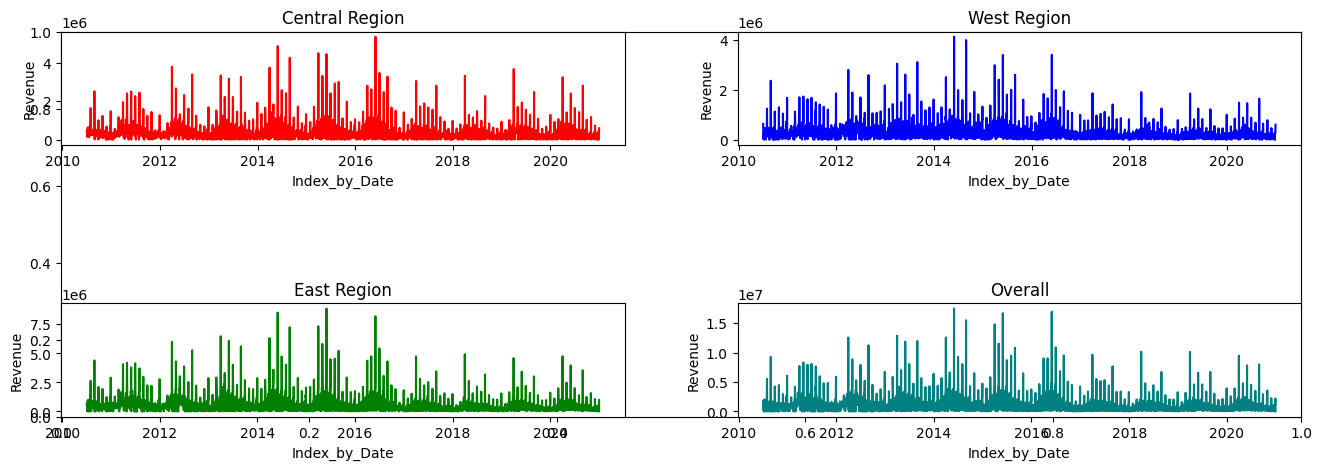

In [7]:
plt.subplots(figsize = (16, 5))

plt.subplot(3,2,1)
sns.lineplot(data=central_train, x=central_train.index, y='Revenue', color = 'red')
plt.title('Central Region')
plt.xlabel('Index_by_Date')

plt.subplot(3,2,2)
sns.lineplot(data=west_train, x=west_train.index, y='Revenue', color = 'blue')
plt.title('West Region')
plt.xlabel('Index_by_Date')

plt.subplot(3,2,5)
sns.lineplot(data=east_train, x=east_train.index, y='Revenue', color = 'green')
plt.title('East Region')
plt.xlabel('Index_by_Date')

plt.subplot(3,2,6)
sns.lineplot(data=main_train, x=main_train.index, y='Revenue', color = 'teal')
plt.title('Overall')
plt.xlabel('Index_by_Date')

## Find Parameter for ARIMA Model

### Use ADFuller to find the parameter d

In [13]:
def find_d(dataset): 
    i = 0
    temp = dataset
    while True:
        result = adfuller(temp['Revenue'].dropna())
        if result[1] < 0.05:
            print(f"Number of difference: {i}")
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
            break
        else:
            temp = temp.diff().dropna()
            i = i+1
            
            if temp["Revenue"].isna().all():  # Prevent infinite loop
                print("All values became NaN after differencing. Check data.")
                break

In [14]:
find_d(main_train)

Number of difference: 1
ADF Statistic: -29.458019
p-value: 0.000000


In [61]:
find_d(central_train)

Number of difference: 1
ADF Statistic: -29.306621
p-value: 0.000000


In [64]:
find_d(west_train)

Number of difference: 1
ADF Statistic: -29.139079
p-value: 0.000000


In [65]:
find_d(east_train)

Number of difference: 1
ADF Statistic: -28.424610
p-value: 0.000000


### Plot ACF and PACF for p and q

In [15]:
def findpq(i, dataset):
  if i == 1:
    X_traindiff = dataset.diff().dropna().dropna()
  if i == 2:
    X_traindiff = dataset.diff().dropna().diff().dropna().dropna()

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  
  # ACF plot (for q selection)
  plot_acf(X_traindiff, lags = 15, ax=axes[0])
  axes[0].set_title("Autocorrelation Function (ACF)")

  # PACF plot (for p selection)
  plot_pacf(X_traindiff,lags = 15, ax=axes[1])
  axes[1].set_title("Partial Autocorrelation Function (PACF)")

  plt.show()


From the ACF and PACF we can conclude the optimal p and q by looking at the lag value right before the drastic drop of value

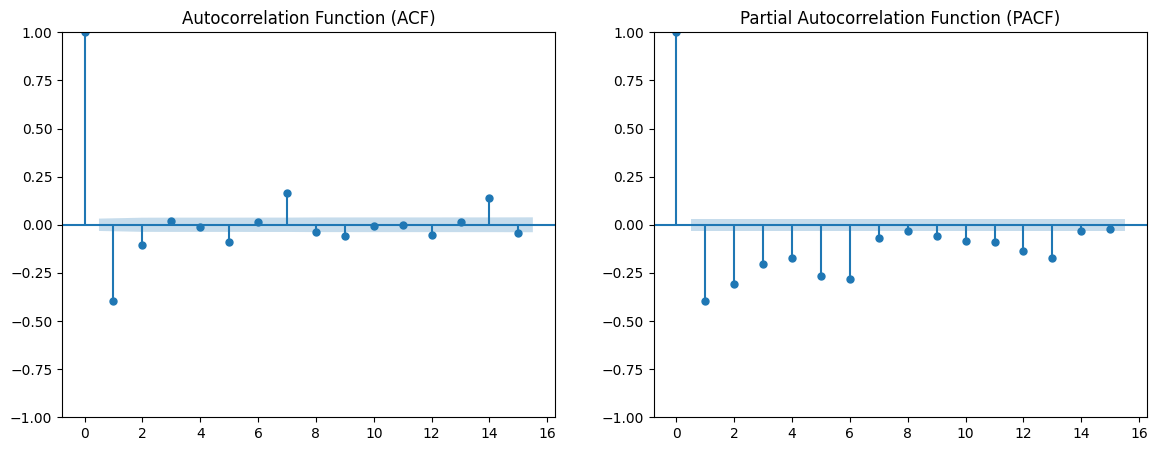

In [16]:
findpq(1, main_train)

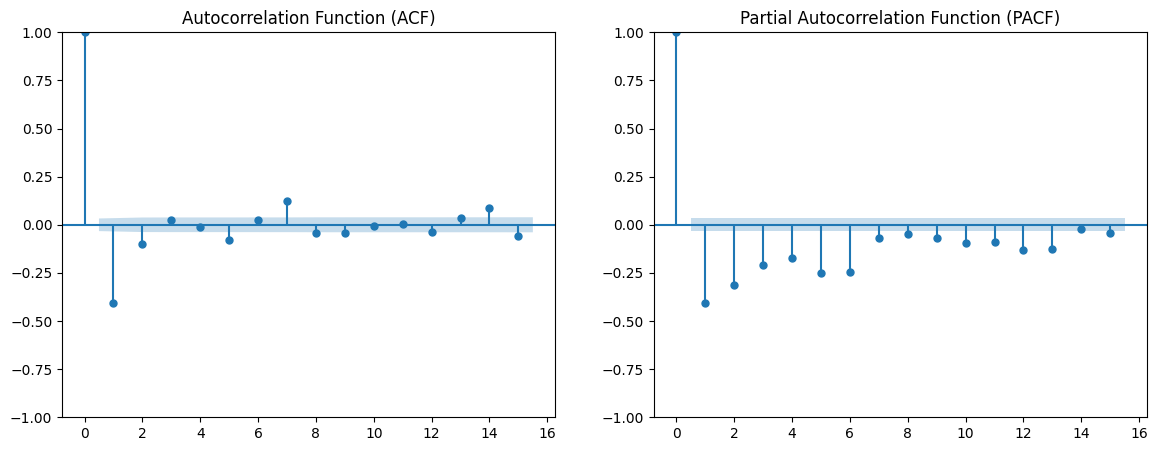

In [95]:
findpq(1, central_train)

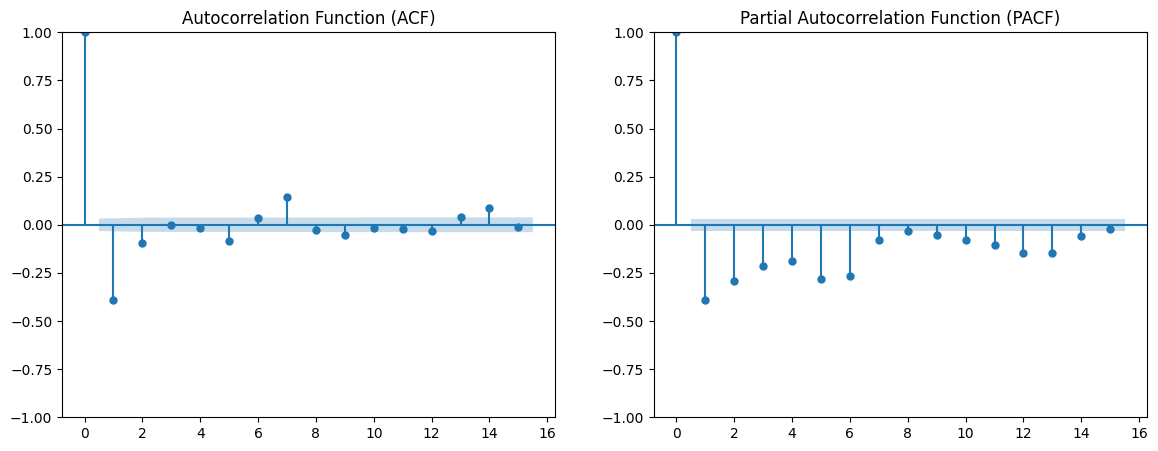

In [97]:
findpq(1, west_train)

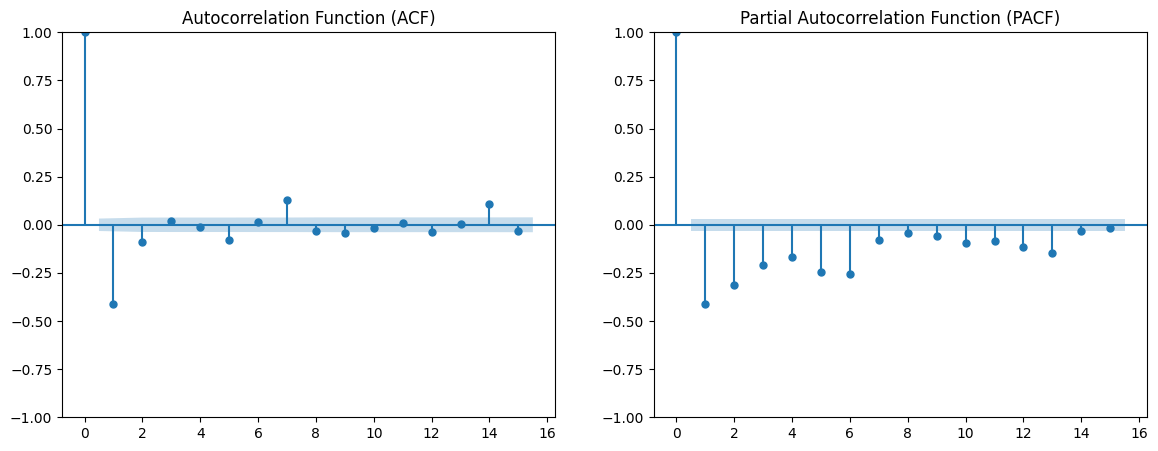

In [98]:
findpq(1, east_train)

### Use Autodetect AutoARIMA to refine the parameter guess

In [29]:
def detect(dataset):
    auto_model = auto_arima(dataset["Revenue"], seasonal=False, trace=True)
    print(auto_model.summary())

In [18]:
detect(main_train)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=114953.389, Time=5.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117002.295, Time=0.18 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=116378.562, Time=0.21 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115179.482, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117000.296, Time=0.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=115044.124, Time=2.15 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=115106.354, Time=1.62 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=115030.338, Time=2.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=115035.108, Time=5.11 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115121.616, Time=1.14 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=114974.325, Time=5.72 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=115104.042, Time=3.52 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=114986.401, Time=15.91 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=114951.362, Time=7.10 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=115042.115, Time=2.90 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=115104.364, Time=1.54 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=115028.334, Time=2.16 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=115033.117, Time=5.86 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=115119.629, Time=1.03 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=114961.816, Time=5.83 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=115102.052, Time=2.44 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=114984.402, Time=11.73 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 84.970 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3718
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -57470.681
Date:                Fri, 21 Feb 2025   AIC                         114951.362
Time:                        08:03:45   BIC                         114982.466
Sample:                             0   HQIC                        114962.429
                               - 3718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0859      0.013     84.750      0.000       1.

In [107]:
detect(central_train)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=101877.259, Time=3.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=103832.525, Time=0.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103194.441, Time=0.17 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102056.998, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103830.525, Time=0.07 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=101946.221, Time=1.22 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=102000.330, Time=0.85 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=101939.125, Time=1.18 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=101940.366, Time=2.78 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=102010.395, Time=0.70 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=101896.095, Time=3.42 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=102000.125, Time=1.23 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=101913.001, Time=4.48 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=101873.700, Time=2.99 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=101944.244, Time=1.20 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=101998.178, Time=0.70 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=101937.148, Time=1.03 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=101938.370, Time=2.48 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=102008.226, Time=0.54 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=101879.356, Time=2.83 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=101997.982, Time=1.04 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=101910.985, Time=4.17 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 37.203 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3569
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -50931.850
Date:                Wed, 19 Feb 2025   AIC                         101873.700
Time:                        13:14:49   BIC                         101904.599
Sample:                             0   HQIC                        101884.716
                               - 3569                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0802      0.014     77.095      0.000       1.0

In [109]:
detect(west_train)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=102630.042, Time=4.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104692.012, Time=0.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104079.382, Time=0.17 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102854.782, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=104690.012, Time=0.06 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=102714.360, Time=1.47 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=102783.707, Time=1.07 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=102651.377, Time=3.68 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=102699.536, Time=3.66 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=102799.179, Time=0.79 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=102628.858, Time=3.23 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=102701.327, Time=1.09 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=102628.665, Time=3.89 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=102683.024, Time=1.26 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=102672.531, Time=4.99 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=102678.994, Time=1.98 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=102664.227, Time=1.90 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=102665.613, Time=8.99 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=102625.477, Time=3.33 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=102681.067, Time=1.17 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=102626.765, Time=2.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=102670.591, Time=6.15 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=102676.849, Time=1.75 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=102699.301, Time=0.92 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0]             : AIC=102661.491, Time=1.67 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=102697.539, Time=2.93 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0]             : AIC=102663.546, Time=8.25 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 72.735 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3676
Model:               SARIMAX(1, 1, 4)   Log Likelihood              -51306.739
Date:                Wed, 19 Feb 2025   AIC                         102625.477
Time:                        13:17:20   BIC                         102662.733
Sample:                             0   HQIC                        102638.740
                               - 3676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8376      0.028     29.535      0.000       0.7

In [111]:
detect(east_train)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=108414.040, Time=3.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110444.320, Time=0.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=109769.355, Time=0.17 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=108595.825, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110442.321, Time=0.07 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=108485.671, Time=2.49 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=108541.972, Time=0.81 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=108478.476, Time=1.26 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=108479.865, Time=3.02 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=108549.568, Time=0.73 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=108432.930, Time=3.05 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=108542.035, Time=1.20 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=108450.292, Time=4.82 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=108411.974, Time=3.33 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=108483.678, Time=2.11 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=108539.987, Time=0.70 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=108476.484, Time=1.16 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=108477.876, Time=2.87 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=108547.585, Time=0.56 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=108418.750, Time=2.65 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=108540.049, Time=1.10 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=108448.280, Time=4.98 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 41.342 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3676
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -54200.987
Date:                Wed, 19 Feb 2025   AIC                         108411.974
Time:                        13:19:21   BIC                         108443.020
Sample:                             0   HQIC                        108423.026
                               - 3676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0820      0.013     85.411      0.000       1.0

### ARIMA for each Region

In [12]:
def arima(p,d,q, dataset, test_data):
  
  model = ARIMA(dataset['Revenue'], order=(p,d,q))  
  model_fit = model.fit()
  print(model_fit.summary())
    
  start = model_fit.nobs
  pred = model_fit.predict(start = start, end= start + len(test_data) - 1, typ = 'levels')
    
  residuals = test_data['Revenue'] - pred
  
  rmse = root_mean_squared_error(test_data['Revenue'], pred)
  mape = mean_absolute_percentage_error(test_data['Revenue'], pred)
  r2 = r2_score(test_data['Revenue'], pred)

  print(f"RMSE: {rmse:.2f}")
  print(f"MAPE: {mape * 100:.2f}%")
  print(f"R²: {r2:.4f}")


In [13]:
arima(1,1,3, main_train, main_test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 3718
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -57475.908
Date:                Sat, 22 Feb 2025   AIC                         114961.816
Time:                        09:19:57   BIC                         114992.919
Sample:                             0   HQIC                        114972.883
                               - 3718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8875      0.018     50.704      0.000       0.853       0.922
ma.L1         -1.7336      0.021    -80.641      0.000      -1.776      -1.691
ma.L2          0.5521      0.037     15.062      0.0

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeEr

In [14]:
arima(2,1,2, central_train, central_test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 3569
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -50931.850
Date:                Sat, 22 Feb 2025   AIC                         101873.700
Time:                        09:20:12   BIC                         101904.599
Sample:                             0   HQIC                        101884.716
                               - 3569                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0802      0.014     77.095      0.000       1.053       1.108
ar.L2         -0.1751      0.015    -11.800      0.000      -0.204      -0.146
ma.L1         -1.9273      0.011   -183.206      0.0

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeEr

In [15]:
arima(1,1,4, west_train, west_test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 3676
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -51306.739
Date:                Sat, 22 Feb 2025   AIC                         102625.477
Time:                        09:20:47   BIC                         102662.733
Sample:                             0   HQIC                        102638.740
                               - 3676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8376      0.028     29.535      0.000       0.782       0.893
ma.L1         -1.6962      0.031    -54.569      0.000      -1.757      -1.635
ma.L2          0.5333      0.042     12.741      0.0

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeEr

In [16]:
arima(2,1,2, east_train, east_test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 3676
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -54200.987
Date:                Sat, 22 Feb 2025   AIC                         108411.974
Time:                        09:20:58   BIC                         108443.020
Sample:                             0   HQIC                        108423.026
                               - 3676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0820      0.013     85.411      0.000       1.057       1.107
ar.L2         -0.1715      0.014    -11.909      0.000      -0.200      -0.143
ma.L1         -1.9334      0.009   -212.320      0.0

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeEr

### Check for Strong Seasonality

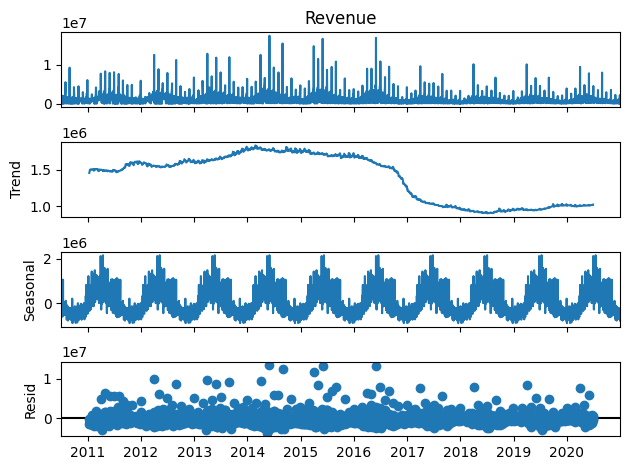

In [26]:
decomposed = seasonal_decompose(main_train['Revenue'], model='additive', period=365) 
decomposed.plot()
plt.show()

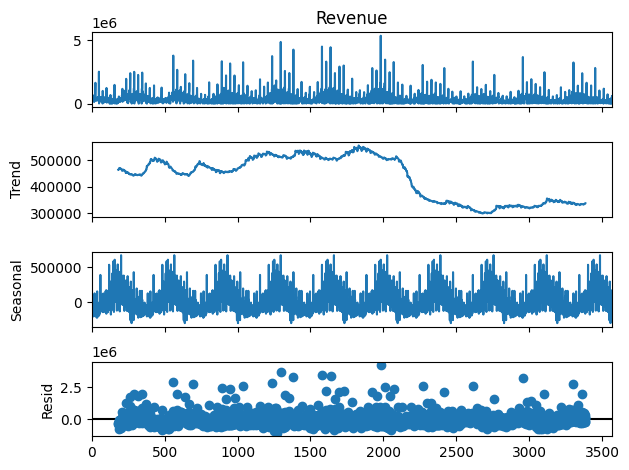

In [59]:
decomposed = seasonal_decompose(central_train['Revenue'], model='additive', period=365) 
decomposed.plot()
plt.show()

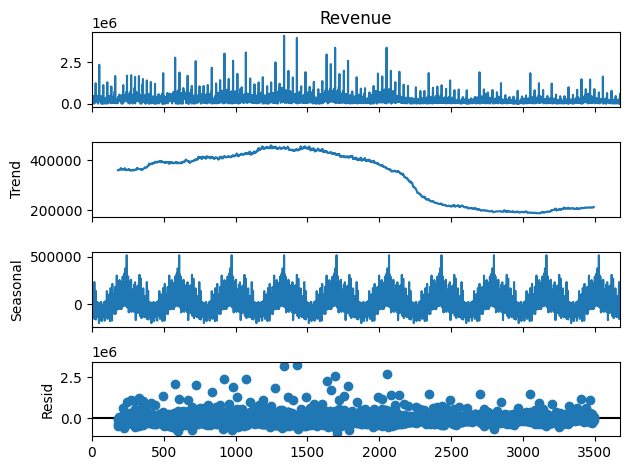

In [60]:
decomposed = seasonal_decompose(west_train['Revenue'], model='additive', period=365)  # Adjust period as needed
decomposed.plot()
plt.show()

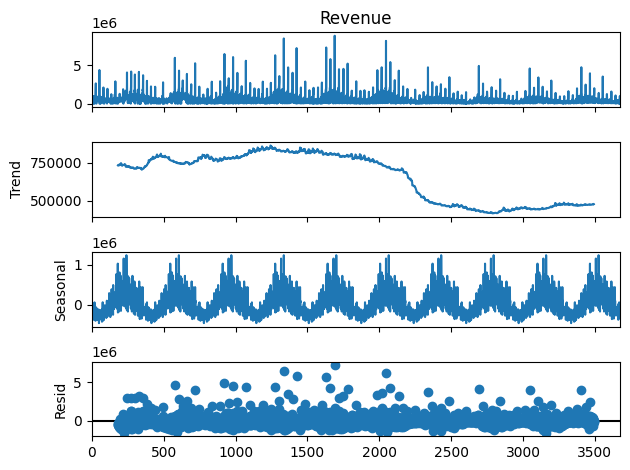

In [61]:
decomposed = seasonal_decompose(east_train['Revenue'], model='additive', period=365)  # Adjust period as needed
decomposed.plot()
plt.show()

### Use SARIMA for handling Seasonality

In [17]:
def sarimax(p, d, q, P, D, Q, s, train_data, test_data):
    
    # Fit SARIMAX model
    model = SARIMAX(train_data['Revenue'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), mle_regression = False)
    model_fit = model.fit(disp=False)
    
    # Forecast for the length of test data
    start = model_fit.nobs
    pred = model_fit.predict(start = start, end= start + len(test_data) - 1, typ = 'levels')
    
    
    # Ensure prediction and test data are aligned
    pred = pred[:len(test_data)]
    
    print(model_fit.summary())
    
    # Calculate evaluation metrics
    rmse = root_mean_squared_error(test_data['Revenue'], pred)
    mape = mean_absolute_percentage_error(test_data['Revenue'], pred)
    r2 = r2_score(test_data['Revenue'], pred)

    # Display metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(train_data.index, train_data['Revenue'], label='Train Data')
    plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data')
    plt.plot(test_data.index, pred, label='Forecast', linestyle='--')
    plt.legend()
    plt.title('SARIMAX Forecast vs Actual')
    plt.show()
    
    return model_fit

### Optimal Parameter for SARIMA can also be calculated using AutoARIMA

In [32]:
def detect_parameter(train_data, p, d, q):
    auto_arima(train_data['Revenue'], seasonal=True, 
        p=p, d=d, q=q,  # We already know p,d,q
        P=None, D=None, Q=None,  # Let auto_arima find seasonal orders
        m=12,  # Seasonal period
        trace=True)

In [33]:
detect_parameter(main_train, 2, 1, 2)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=114938.643, Time=17.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=117002.295, Time=0.15 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=116365.047, Time=1.21 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=115174.379, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=117000.296, Time=0.13 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=114943.299, Time=13.68 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=114944.968, Time=13.18 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=114932.021, Time=46.37 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=114932.804, Time=37.12 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=114871.443, Time=43.21 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=114940.901, Time=40.74 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=31.56 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=114986.719, Time=35.71 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=114886.454, Time=32.34 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[12] intercept   : AIC=114891.545, Time=67.96 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=115008.704, Time=26.08 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[12] intercept   : AIC=114883.219, Time=54.69 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12] intercept   : AIC=114983.409, Time=39.40 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[12] intercept   : AIC=114875.136, Time=100.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12]             : AIC=114867.094, Time=58.96 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12]             : AIC=114938.243, Time=68.87 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12]             : AIC=114930.030, Time=67.09 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=114936.599, Time=23.81 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12]             : AIC=inf, Time=46.20 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12]             : AIC=114984.728, Time=51.06 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[12]             : AIC=114884.451, Time=51.84 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[12]             : AIC=114887.725, Time=85.10 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12]             : AIC=115006.717, Time=31.47 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[12]             : AIC=114857.111, Time=60.53 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,2)[12]             : AIC=114942.921, Time=60.63 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,1)[12]             : AIC=114940.212, Time=56.19 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[12]             : AIC=114948.330, Time=26.32 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(2,0,2)[12]             : AIC=114896.079, Time=45.70 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(2,0,2)[12]             : AIC=114857.542, Time=86.51 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12]             : AIC=114927.760, Time=32.44 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(2,0,2)[12]             : AIC=114884.561, Time=70.43 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(2,0,2)[12]             : AIC=inf, Time=98.72 sec

Best model:  ARIMA(1,1,3)(2,0,2)[12]          
Total fit time: 1626.029 seconds


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

                                        SARIMAX Results                                        
Dep. Variable:                                 Revenue   No. Observations:                 3718
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -57419.555
Date:                                 Sat, 22 Feb 2025   AIC                         114857.111
Time:                                         09:22:29   BIC                         114913.097
Sample:                                              0   HQIC                        114877.030
                                                - 3718                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9027      0.024     37.535      0.000       0.856       0

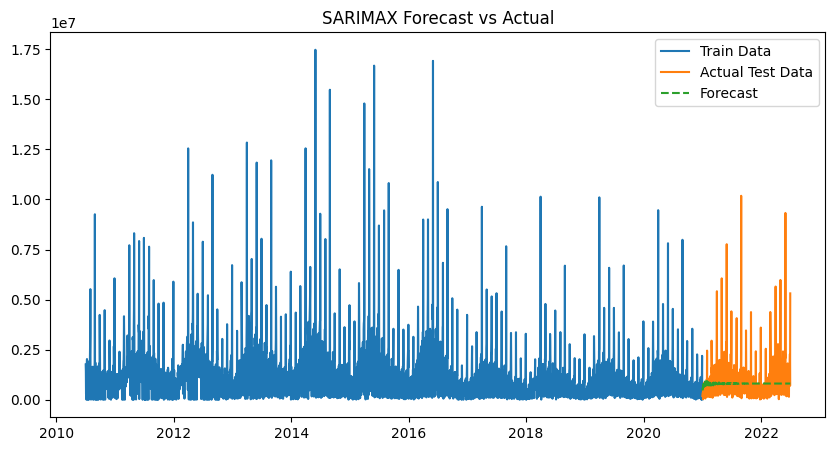

In [18]:
sarimax(1,1,3,2,0,2, 12, main_train, main_test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                 3569
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 12)   Log Likelihood              -50928.099
Date:                            Sat, 22 Feb 2025   AIC                         101870.198
Time:                                    09:23:35   BIC                         101913.456
Sample:                                         0   HQIC                        101885.621
                                           - 3569                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0779      0.014     75.498      0.000       1.050       1.106
ar.L2         -0.1737      0.015   

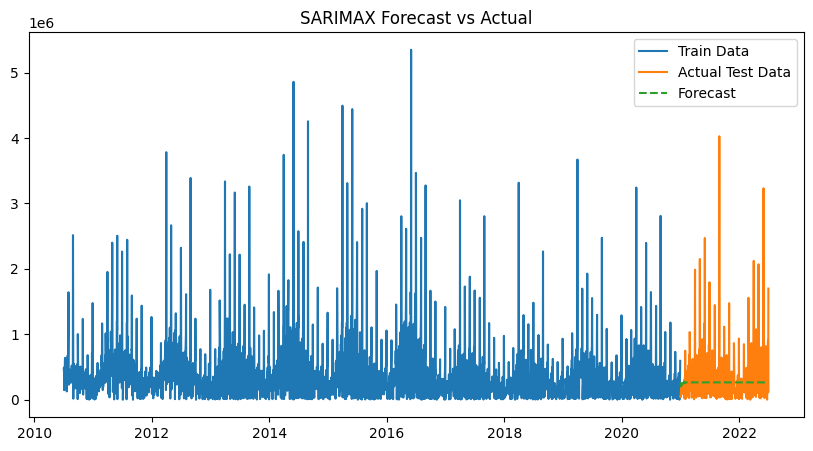

In [19]:
sarimax(2,1,2,0,0,2,12, central_train, central_test)

#### Use Sarimax to forecast for Year 2023

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

def sarimax_forecast(p, d, q, P, D, Q, s, train_data, test_data, future_periods=12):
    
    # Fit SARIMAX model
    model = SARIMAX(train_data['Revenue'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), 
                    mle_regression=False)
    model_fit = model.fit(disp=False)
    
    # Forecast for test data
    start = model_fit.nobs
    pred_test = model_fit.predict(start=start, end=start + len(test_data) - 1, typ='levels')
    
    # Forecast for future periods
    future_index = pd.date_range(start=test_data.index[-1], periods=future_periods + 1, freq='M')[1:]
    pred_future = model_fit.predict(start=start + len(test_data), end=start + len(test_data) + future_periods - 1, typ='levels')
    
    # Calculate evaluation metrics on test data
    rmse = root_mean_squared_error(test_data['Revenue'], pred_test)
    mape = mean_absolute_percentage_error(test_data['Revenue'], pred_test)
    r2 = r2_score(test_data['Revenue'], pred_test)
    
    # Display metrics
    print(model_fit.summary())
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R²: {r2:.4f}")

    # Plot predictions vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Revenue'], label='Train Data')
    plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data')
    plt.plot(test_data.index, pred_test, label='Test Forecast', linestyle='--')
    plt.plot(future_index, pred_future, label='Future Forecast (2023)', linestyle='dotted', color='red')
    plt.legend()
    plt.title('SARIMAX Forecast vs Actual')
    plt.show()
    
    return model_fit, pred_future

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

                                        SARIMAX Results                                        
Dep. Variable:                                 Revenue   No. Observations:                 3718
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -57419.555
Date:                                 Sat, 22 Feb 2025   AIC                         114857.111
Time:                                         09:24:58   BIC                         114913.097
Sample:                                              0   HQIC                        114877.030
                                                - 3718                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9027      0.024     37.535      0.000       0.856       0

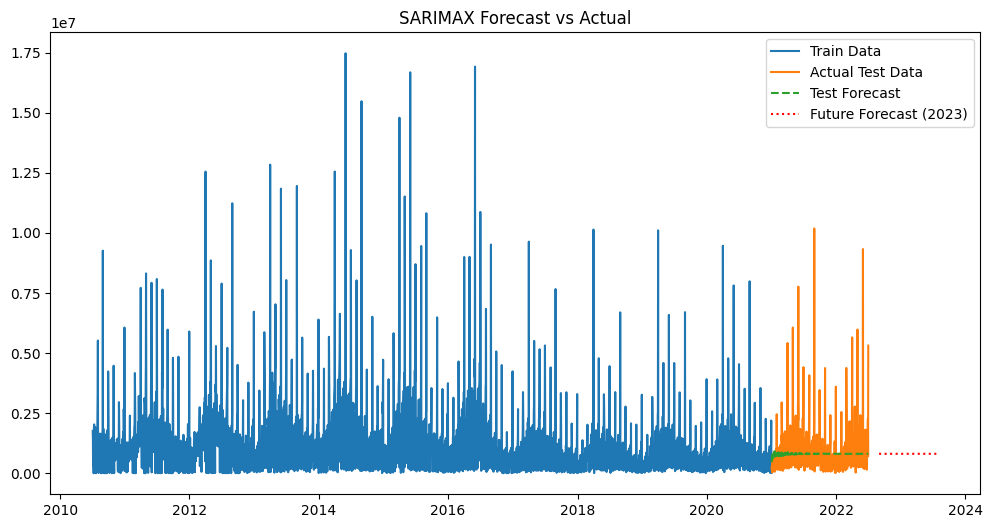

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x27aa0d4b890>,
 4253    811210.512801
 4254    811270.692323
 4255    811239.800129
 4256    811374.702658
 4257    811169.793855
 4258    811236.500820
 4259    811189.462874
 4260    811156.332861
 4261    811219.644323
 4262    811227.400769
 4263    811487.887093
 4264    811275.585343
 Name: predicted_mean, dtype: float64)

In [22]:
sarimax_forecast(1, 1, 3, 2, 0, 2, 12, main_train, main_test, 12)

### Comment
- The ARIMA model is susceptible with large dataset and requires huge Computational Cost to fine-tune the parameters

- One major disadvantage of the Dataset is the need to aggregate Revenue based on Dates, which will clear out every other categorical data, thus reducing the predictive accuracy

- The bad Performance Metrics is mainly due to the lack of fine-tuned hyperparameter like m, which can be set to 365 or other smaller timestamps to increase R^2 and reduce error

- However, this will act as a base for other more efficient ts models